The data has been collected from Food.com (formerly GeniusKitchen), under the provision that any resulting
work should cite this resource:
Generating Personalized Recipes from Historical User Preferences. Bodhisattwa Prasad Majumder,
Shuyang Li, Jianmo Ni, Julian McAuley, in Proceedings of the 2019 Conference on Empirical
Methods in Natural Language Processing and the 9th International Joint Conference on Natural
Language Processing (EMNLP-IJCNLP), 2019

In [1]:
#directory. 
import os
os.chdir('/Users/~/Desktop/Assignment 2 Machine Learning')
os.getcwd()

'C:\\Users\\~\\Desktop\\Assignment 2 Machine Learning'

In [2]:
#importing all packages.

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier
import lightgbm as lgbm
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from itertools import zip_longest
import csv

# Reading All required files. 

In [7]:
train_name_doc2vec50 = pd.read_csv(r"train_name_doc2vec50.csv", index_col = False, delimiter = ',', header=None)
train_steps_doc2vec50 = pd.read_csv(r"train_steps_doc2vec50.csv", index_col = False, delimiter = ',', header=None)
train_ingr_doc2vec50 = pd.read_csv(r"train_ingr_doc2vec50.csv", index_col = False, delimiter = ',', header=None)
test_name_doc2vec50 = pd.read_csv(r"test_name_doc2vec50.csv", index_col = False, delimiter = ',', header=None)
test_steps_doc2vec50 = pd.read_csv(r"test_steps_doc2vec50.csv", index_col = False, delimiter = ',', header=None)
test_ingr_doc2vec50 = pd.read_csv(r"test_ingr_doc2vec50.csv", index_col = False, delimiter = ',', header=None)
x_train_original = pd.read_csv(r"recipe_train.csv", index_col = False, delimiter = ',', header=0)
x_test_original = pd.read_csv(r"recipe_test.csv", index_col = False, delimiter = ',', header=0)

# Functions used later in code

In [8]:
#gets a csv file for all predictions. 

def csvfile(List_of_pred):
    index = [i for i in range(1,10001)]
    d = [index, List_of_pred]
    export_data = zip_longest(*d, fillvalue = '')
    with open('Final_predictions.csv', 'w', encoding="ISO-8859-1", newline='') as myfile:
        wr = csv.writer(myfile)
        wr.writerow(("id", "duration_label"))
        wr.writerows(export_data)
    myfile.close()

In [9]:
# function which takes individual features and return on data set. 
def final_df(name_df, numeric_df, steps_df, ingr_df):
    dataframe = pd.concat([name_df,numeric_df,steps_df,ingr_df ],axis = 1)
    return dataframe

In [10]:
def minimal_mutual_info(mutual_info_list):
    count = 0
    for i in range(len(mutual_info)):
        if mutual_info[i] <= 0.001:
            count+=1
    return count    
    

# Feature Engineering. 

In [11]:
#converting data into useful format for training and testing
x_train_original_numeric = x_train_original.iloc[:,1:3]
x_test_original_numeric = x_test_original.iloc[:,1:3]

# giving proper names to columns. 
column_names = ["name"+str(i) for i in range(1,51)]
column_steps = ["steps"+str(i) for i in range(1,51)]
column_ingr = ["ingr"+str(i) for i in range(1,51)]

#training set
train_name_doc2vec50.columns = column_names
train_steps_doc2vec50.columns = column_steps
train_ingr_doc2vec50.columns = column_ingr

#test set.
test_name_doc2vec50.columns = column_names
test_steps_doc2vec50.columns = column_steps
test_ingr_doc2vec50.columns = column_ingr


train_df = final_df(train_name_doc2vec50,x_train_original_numeric,train_steps_doc2vec50,train_ingr_doc2vec50)
test_df = final_df(test_name_doc2vec50,x_test_original_numeric,test_steps_doc2vec50,test_ingr_doc2vec50)
target_data = x_train_original.iloc[:,-1]

In [12]:
train_df.head()

,name1,name2,name3,name4,name5,name6,name7,name8,name9,name10,...,ingr41,ingr42,ingr43,ingr44,ingr45,ingr46,ingr47,ingr48,ingr49,ingr50
0,-0.040233,0.076782,0.249360,-0.181925,0.248722,-0.588148,0.535760,-0.060977,-0.376367,0.119354,...,-0.162645,-0.326292,0.410408,0.196359,-0.422395,0.140098,0.222497,0.257018,0.092791,0.090195
1,-0.171015,0.076204,0.016986,-0.208875,-0.241924,-0.235768,0.214952,-0.229491,-0.083370,0.026395,...,0.121136,-0.050538,0.276983,0.164212,-0.082383,-0.367911,-0.049660,-0.249535,-0.330310,0.286444
2,-0.004516,0.002639,0.045212,0.064354,-0.295956,-0.030037,-0.125290,0.060692,-0.252764,-0.117760,...,0.127530,-0.133198,-0.019909,-0.104222,0.068053,0.208893,-0.100972,-0.016045,0.208270,0.192634
3,0.398416,-0.289314,0.120874,-0.109078,0.172739,-0.329223,-0.174549,0.240794,-0.020434,-0.149348,...,-0.164667,0.216565,-0.040816,-0.095826,0.253930,-0.500503,0.204917,-0.244062,-0.078134,-0.125225
4,-0.024000,0.188942,-0.060302,0.114219,-0.021253,0.168473,-0.003027,0.020890,-0.256069,0.276312,...,0.393460,-0.138803,0.130013,-0.115817,0.203033,0.105802,0.081311,-0.351688,-0.188493,0.065571


In [13]:
test_df.head()

,name1,name2,name3,name4,name5,name6,name7,name8,name9,name10,...,ingr41,ingr42,ingr43,ingr44,ingr45,ingr46,ingr47,ingr48,ingr49,ingr50
0,-0.074475,0.043355,-0.200122,0.562771,0.051261,-0.283168,0.023642,0.206712,-0.420130,0.085731,...,0.095193,0.043306,0.144705,0.398941,0.479444,-0.042382,-0.563529,-0.279356,0.579330,0.244928
1,-0.083797,-0.119397,0.055886,0.459259,-0.129858,0.275230,-0.274989,0.099745,-0.486215,0.059932,...,0.211689,-0.055173,0.340421,-0.364482,0.068267,-0.344242,0.210038,-0.117994,-0.280759,0.021039
2,-0.188450,0.037819,-0.098069,-0.140659,-0.056237,-0.074347,0.172098,0.102223,-0.093355,0.156367,...,0.167190,0.003652,0.210495,0.032370,0.037029,-0.014407,0.171625,0.056638,-0.348820,0.037014
3,0.039180,0.458914,0.201800,0.052737,-0.095670,0.231523,0.064118,-0.170139,-0.197386,-0.235173,...,-0.154911,-0.158520,-0.017566,0.089600,0.601790,0.221260,0.252161,-0.453007,-0.054874,0.173056
4,0.235192,-0.201566,-0.543494,-0.418995,-0.186713,0.058639,-0.241507,0.522636,0.674384,-0.038818,...,-0.448365,-0.050810,0.039446,-0.376570,0.355938,-0.092240,0.105215,-0.005017,-0.404264,-0.155049


In [14]:
# determine the mutual information
mutual_info = mutual_info_classif(train_df, target_data)
low_mutual_info = minimal_mutual_info(mutual_info)
print("number of features to be removed are :",low_mutual_info)

number of features to be removed are : 28


In [15]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = train_df.columns
mutual_info.sort_values(ascending=False)

n_steps          0.074356
n_ingredients    0.048853
steps4           0.029808
steps10          0.024017
steps8           0.021238
                   ...   
name19           0.000000
steps38          0.000000
name14           0.000000
name13           0.000000
name47           0.000000
Length: 152, dtype: float64

<AxesSubplot:>

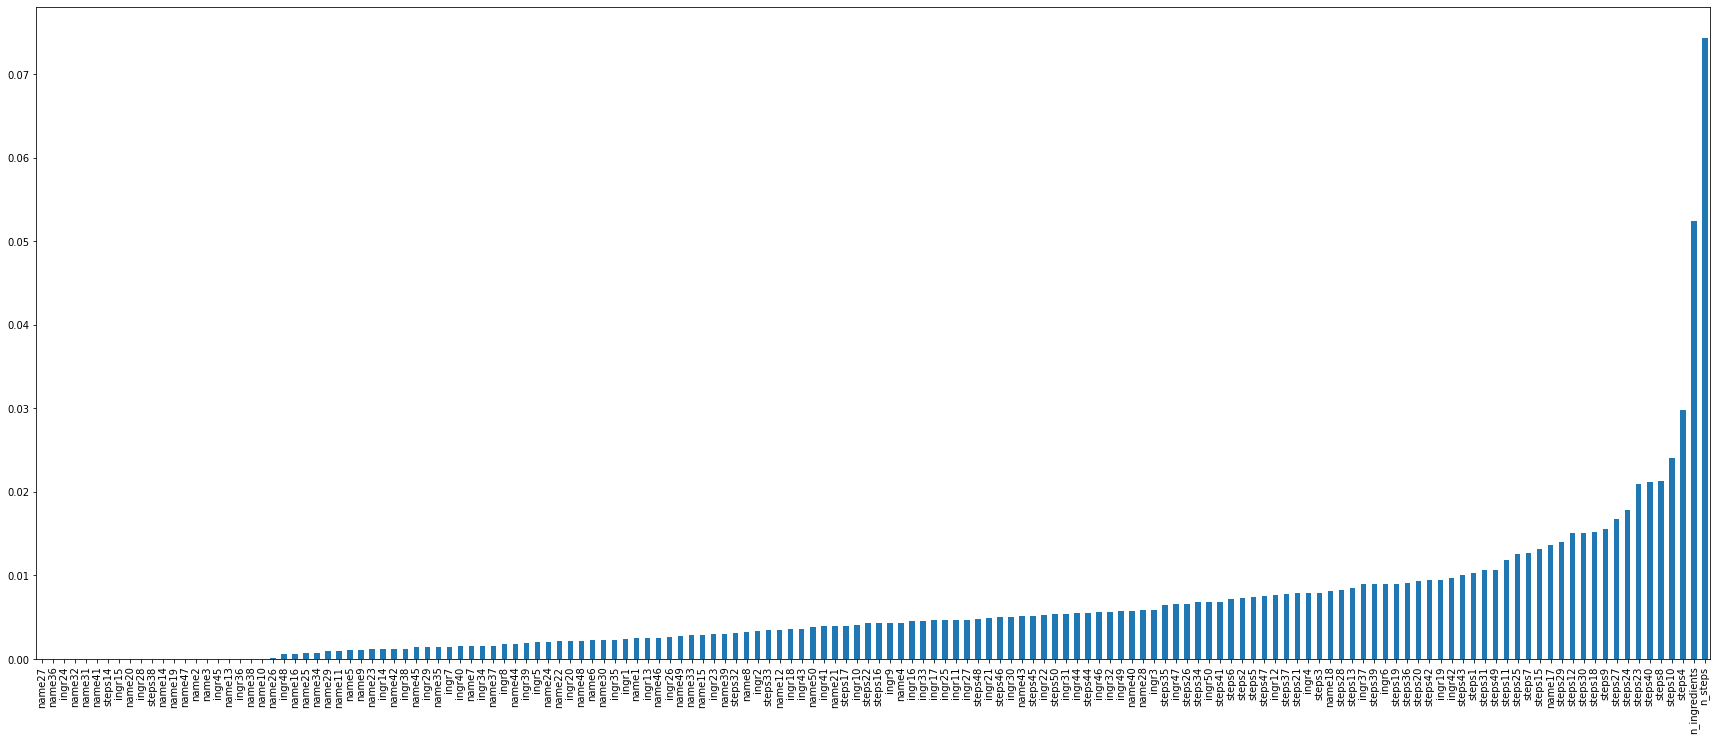

In [12]:
#Ploting Mutual info value per feature ordered ascending
mutual_info.sort_values(ascending=True).plot.bar(figsize=(30, 12))

In [16]:
#Using Select K best to pick all those feature that has mutual info greater than 0.0001
sel_cols = SelectKBest(mutual_info_classif, k=152-low_mutual_info)
sel_cols.fit(train_df, target_data)
importent_features = train_df.columns[sel_cols.get_support()]

#getting all those feature that has low mutual info.
not_importent_features = []
for i in train_df.columns:
    if i not in importent_features:
        not_importent_features.append(i)

#droping all atrributes with mutual info lower than 0.0001
new_train_df = train_df.drop(not_importent_features,axis = 1)
new_test_df = test_df.drop(not_importent_features,axis = 1)

In [17]:
new_train_df.head()

,name1,name4,name5,name6,name7,name8,name9,name12,name15,name17,...,ingr39,ingr40,ingr41,ingr42,ingr43,ingr44,ingr46,ingr47,ingr49,ingr50
0,-0.040233,-0.181925,0.248722,-0.588148,0.535760,-0.060977,-0.376367,0.386682,0.408220,0.142330,...,0.392138,0.106890,-0.162645,-0.326292,0.410408,0.196359,0.140098,0.222497,0.092791,0.090195
1,-0.171015,-0.208875,-0.241924,-0.235768,0.214952,-0.229491,-0.083370,-0.060472,-0.080486,0.219200,...,0.302997,-0.030763,0.121136,-0.050538,0.276983,0.164212,-0.367911,-0.049660,-0.330310,0.286444
2,-0.004516,0.064354,-0.295956,-0.030037,-0.125290,0.060692,-0.252764,0.073588,0.383516,-0.046216,...,0.112140,-0.035325,0.127530,-0.133198,-0.019909,-0.104222,0.208893,-0.100972,0.208270,0.192634
3,0.398416,-0.109078,0.172739,-0.329223,-0.174549,0.240794,-0.020434,0.057860,0.139197,0.056660,...,-0.627608,0.036760,-0.164667,0.216565,-0.040816,-0.095826,-0.500503,0.204917,-0.078134,-0.125225
4,-0.024000,0.114219,-0.021253,0.168473,-0.003027,0.020890,-0.256069,-0.145888,-0.089568,0.067521,...,0.478597,-0.114830,0.393460,-0.138803,0.130013,-0.115817,0.105802,0.081311,-0.188493,0.065571


In [18]:
new_test_df.head()

,name1,name4,name5,name6,name7,name8,name9,name12,name15,name17,...,ingr39,ingr40,ingr41,ingr42,ingr43,ingr44,ingr46,ingr47,ingr49,ingr50
0,-0.074475,0.562771,0.051261,-0.283168,0.023642,0.206712,-0.420130,-0.034159,-0.487468,0.150735,...,0.214489,-0.343873,0.095193,0.043306,0.144705,0.398941,-0.042382,-0.563529,0.579330,0.244928
1,-0.083797,0.459259,-0.129858,0.275230,-0.274989,0.099745,-0.486215,-0.016686,-0.531290,0.458483,...,-0.164688,0.334487,0.211689,-0.055173,0.340421,-0.364482,-0.344242,0.210038,-0.280759,0.021039
2,-0.188450,-0.140659,-0.056237,-0.074347,0.172098,0.102223,-0.093355,0.011382,0.262220,-0.012550,...,-0.181852,-0.140984,0.167190,0.003652,0.210495,0.032370,-0.014407,0.171625,-0.348820,0.037014
3,0.039180,0.052737,-0.095670,0.231523,0.064118,-0.170139,-0.197386,-0.445906,0.350756,-0.224878,...,0.723642,0.027863,-0.154911,-0.158520,-0.017566,0.089600,0.221260,0.252161,-0.054874,0.173056
4,0.235192,-0.418995,-0.186713,0.058639,-0.241507,0.522636,0.674384,-0.445096,-0.297151,0.341258,...,0.123184,-0.087516,-0.448365,-0.050810,0.039446,-0.376570,-0.092240,0.105215,-0.404264,-0.155049


From this point onwards we consider training data set that has 124 features( columns )

# All Considered Classifiers.

# KNN classifier

In [19]:
pipe = Pipeline(steps = [("SS",StandardScaler()),("KNN",KNeighborsClassifier(weights = 'distance'))])
param_grid = {'KNN__n_neighbors':[70,80,100]}
gs_cv = GridSearchCV(estimator = pipe, param_grid=param_grid, cv = 3, n_jobs = -1, scoring = "accuracy")
gs_cv.fit(new_train_df,target_data)
print("Best parameter (CV score = %0.6f):" % gs_cv.best_score_)
print(gs_cv.best_params_)

# lower column dimensions implies KNN is adversely affected by many number of features.

Best parameter (CV score = 0.581650):
{'KNN__n_neighbors': 70}


The best KNN model from above evaluation is KNN with n_neighbours = 70.

# Support Vector Machine. 

In [20]:
pipe2 = Pipeline(steps = [("SS",StandardScaler()), ('svm',SVC(class_weight = "balanced"))])

In [23]:
param_grid = {'svm__kernel' :['rbf','poly']}
gs_cv = GridSearchCV(estimator = pipe2, param_grid=param_grid, cv = 3, n_jobs = -1, scoring = "accuracy")
gs_cv.fit(new_train_df,target_data)
print("Best parameter (CV score = %0.6f):" % gs_cv.best_score_)
print(gs_cv.best_params_)

Best parameter (CV score = 0.726600):
{'svm__kernel': 'rbf'}


Thge best SVM model from above code is SVM with kernal radial basis function.

# Gradient Boosting Classifier ( lightgbm )

We do not check for certian hyperparameters, since it makes sense from data, what to consider. For examnple objective = multiclass is trivial to decide since we are dealing with multi class case. 

In [21]:
pipe3 = Pipeline(steps = [('SS',StandardScaler()),("lgbm",lgbm.LGBMClassifier(objective = 'multiclass',metric = 'multi_logloss',num_class =3))])
                          

In [22]:
param_grid = {'lgbm__learning_rate':[0.05,0.08,0.09],'lgbm__min_child_samples' :[10,20,30] }
gs_cv = GridSearchCV(estimator = pipe3, param_grid=param_grid, cv = 3, n_jobs = -1, scoring = "accuracy")
gs_cv.fit(new_train_df,target_data)
print("Best parameter (CV score = %0.6f):" % gs_cv.best_score_)
print(gs_cv.best_params_)

Best parameter (CV score = 0.718725):
{'lgbm__learning_rate': 0.09, 'lgbm__min_child_samples': 30}


The best model turns out to be lgbm with learning rate 0.09 and min_ chile samples = 30. 

# Logistic Regression 

In [136]:
pipe4 = Pipeline(steps = [('SS',StandardScaler()), ('LR', LogisticRegression())])

In [138]:
param_grid = {'LR__class_weight':['None','balanced'], 'LR__multi_class':['ovr', 'multinomial'],'LR__solver':["sag","saga"]}
gs_cv = GridSearchCV(estimator = pipe4, param_grid=param_grid, cv = 3, n_jobs = -1, scoring = "accuracy")
gs_cv.fit(new_train_df,target_data)
print("Best parameter (CV score = %0.6f):" % gs_cv.best_score_)
print(gs_cv.best_params_)

C:\Users\~\.conda\envs\tenserflow-sessions\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.71237505 0.71237505        nan        nan 0.6678999  0.67174999
 0.64222511 0.64275012]
  warnings.warn(


Best parameter (CV score = 0.712375):
{'LR__class_weight': 'None', 'LR__multi_class': 'ovr', 'LR__solver': 'sag'}


The LR model from above code turns out be one with hyper parameters class_weight = None, LR multi class = 'ovr' and LR Solver = sag

# Stacking Model. 


In [24]:
#scaling data for better results and less computational cost.
scaler = StandardScaler()
scaler.fit(new_train_df)
scaled_data = scaler.transform(new_train_df)

In [39]:
#train and test split.
X_train_check, X_test_check, y_train_check, y_test_check = train_test_split(scaled_data, target_data, test_size=0.25, random_state=42)

In [40]:
def stacking():
    
    # define the base models
    level_base = list()
    level_base.append(('lr',LogisticRegression(multi_class = 'ovr', solver = "sag")))
    level_base.append(('svm',SVC(kernel = 'rbf')))
    level_base.append(("lgbm",lgbm.LGBMClassifier(objective = 'multiclass',metric = 'multi_logloss',num_class =3,boosting_type = 'gbdt',learning_rate = 0.09, min_child_samples = 30)))
    # define meta learner model
    level_1 = LogisticRegression(multi_class = 'ovr',solver = 'sag')
    #stacking ensemble model.
    model = StackingClassifier(estimators=level_base, final_estimator=level_1, cv=5)
  
    return model

In [41]:
# get a list of models to evaluate
def get_models():
    models = dict()
    models['LogesticRegression'] = LogisticRegression(multi_class = 'multinomial', solver = "saga")
    models['svm'] = SVC(kernel = 'rbf')
    models['light_gbm'] = lgbm.LGBMClassifier(objective = 'multiclass',metric = 'multi_logloss',num_class =3,boosting_type = 'gbdt',learning_rate = 0.09, min_child_samples = 30)
    models['stacking'] = stacking()
    return models

In [42]:
def evaluate_model(model):
    cv = StratifiedKFold(n_splits=3)
    scores = cross_val_score(model, X_train_check, y_train_check, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

In [43]:
from sklearn.model_selection import cross_val_score
models = get_models()
# evaluating model based on accuracy. 
results = list()
names = list()
for name, model in models.items():
    scores= evaluate_model(model)
    results.append(scores)
    names.append(name)
    print('accuracy for %s = %.6f' % (name, np.mean(scores)))

accuracy for LogesticRegression = 0.714233
accuracy for svm = 0.731700
accuracy for light_gbm = 0.719133
accuracy for stacking = 0.731200


In [44]:
#scaling the test data for final prediction
scaler.fit(new_test_df)
scaled_data_test = scaler.transform(new_test_df)
#fitting the model on complete data 40000 samples
model.fit(scaled_data,target_data)
pred = model.predict(scaled_data_test)

In [45]:
#checking if number of prediction is correct
print(len(pred))

10000


In [46]:
#importing the csv file for kaggle submission
csvfile(pred)

All the code below was used to generate table/graphs for Report.

In [49]:
import matplotlib.pyplot as plt

#PCA Visualization. 
pca = PCA(n_components = 3)
pca.fit(scaled_data)
new_x = pca.transform(scaled_data)
#plt.figure()
#plt.scatter(new_x[:,0],new_x[:,1], c = target_data)

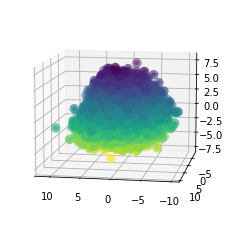

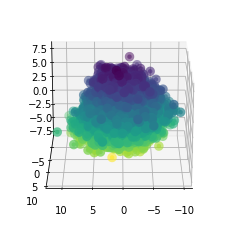

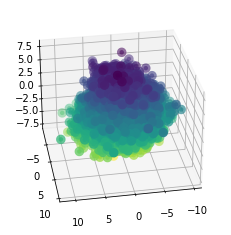

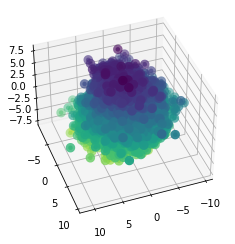

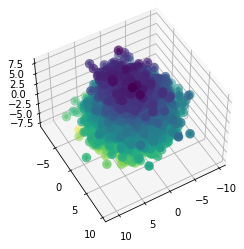

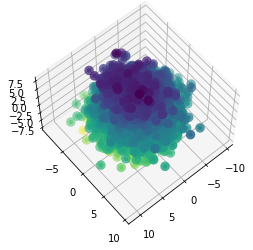

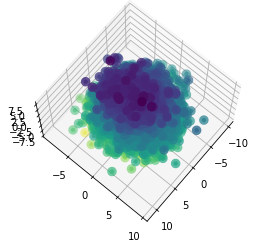

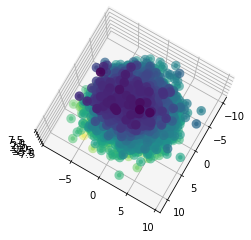

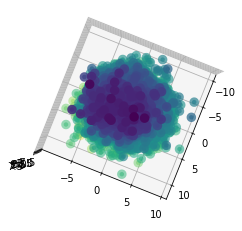

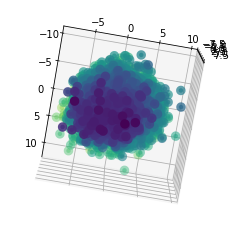

In [52]:
from mpl_toolkits import mplot3d
%matplotlib inline

zdata = new_x[:,0]
xdata = new_x[:,1]
ydata = new_x[:,2]

for i in range(10,101,10):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.scatter3D(xdata, ydata, zdata, c=zdata,cmap='viridis_r', linewidth=5)
    ax.view_init(i, 110-i)